## Feature Engineering & Justification

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from itertools import product
import copy


from data_preprocessing import * 
from feature_engineering import * 

c:\Users\olenk\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [3]:
import warnings
warnings.filterwarnings("ignore")

#### Data Loading

In [22]:
stormEvents_2014 = pd.read_csv("../data/NOAA_StormEvents/StormEvents_details-ftp_v1.0_d2014_c20231116.csv")
stormEvents_2015 = pd.read_csv("../data/NOAA_StormEvents/StormEvents_details-ftp_v1.0_d2015_c20240716.csv")
stormEvents_2016 = pd.read_csv("../data/NOAA_StormEvents/StormEvents_details-ftp_v1.0_d2016_c20220719.csv")
stormEvents_2017 = pd.read_csv("../data/NOAA_StormEvents/StormEvents_details-ftp_v1.0_d2017_c20230317.csv")
stormEvents_2018 = pd.read_csv("../data/NOAA_StormEvents/StormEvents_details-ftp_v1.0_d2018_c20240716.csv")
stormEvents_2019 = pd.read_csv("../data/NOAA_StormEvents/StormEvents_details-ftp_v1.0_d2019_c20240117.csv")
stormEvents_2020 = pd.read_csv("../data/NOAA_StormEvents/StormEvents_details-ftp_v1.0_d2020_c20240620.csv")
stormEvents_2021 = pd.read_csv("../data/NOAA_StormEvents/StormEvents_details-ftp_v1.0_d2021_c20240716.csv")
stormEvents_2022 = pd.read_csv("../data/NOAA_StormEvents/StormEvents_details-ftp_v1.0_d2022_c20241121.csv")
stormEvents_2023 = pd.read_csv("../data/NOAA_StormEvents/StormEvents_details-ftp_v1.0_d2023_c20241216.csv")

stormEvents_dfs = [stormEvents_2014, stormEvents_2015, stormEvents_2016, stormEvents_2017, stormEvents_2018,
       stormEvents_2019, stormEvents_2020, stormEvents_2021, stormEvents_2022, stormEvents_2023]


In [23]:
eaglei_outages_2014 = pd.read_csv("../data/eaglei_data/eaglei_outages_2014.csv")
eaglei_outages_2015 = pd.read_csv("../data/eaglei_data/eaglei_outages_2015.csv")
eaglei_outages_2016 = pd.read_csv("../data/eaglei_data/eaglei_outages_2016.csv")
eaglei_outages_2017 = pd.read_csv("../data/eaglei_data/eaglei_outages_2017.csv")
eaglei_outages_2018 = pd.read_csv("../data/eaglei_data/eaglei_outages_2018.csv")
eaglei_outages_2019 = pd.read_csv("../data/eaglei_data/eaglei_outages_2019.csv")
eaglei_outages_2020 = pd.read_csv("../data/eaglei_data/eaglei_outages_2020.csv")
eaglei_outages_2021 = pd.read_csv("../data/eaglei_data/eaglei_outages_2021.csv")
eaglei_outages_2022 = pd.read_csv("../data/eaglei_data/eaglei_outages_2022.csv")
eaglei_outages_2023 = pd.read_csv("../data/eaglei_data/eaglei_outages_2023.csv")


outages_dfs = [eaglei_outages_2014, eaglei_outages_2015, eaglei_outages_2016, eaglei_outages_2017, eaglei_outages_2018,
               eaglei_outages_2019, eaglei_outages_2020, eaglei_outages_2021, eaglei_outages_2022, eaglei_outages_2023]

In [24]:
weather_data = load_data('../data/weather_data/weather_data.csv')

In [25]:
mcc = pd.read_csv("../data/eaglei_data/MCC.csv")

__________________________________________________________________________________

## Eaglei_Outages

#### Cleaning datasets

We want to filter the `eaglei_outages_{year}` data frames in a way that preserves the highest quality data and correctly fills in any gaps. We do not want to lose data from excessively large territories to ensure our model performs as well as possible. At the same time, we want to exclude counties that reported the least consistently.

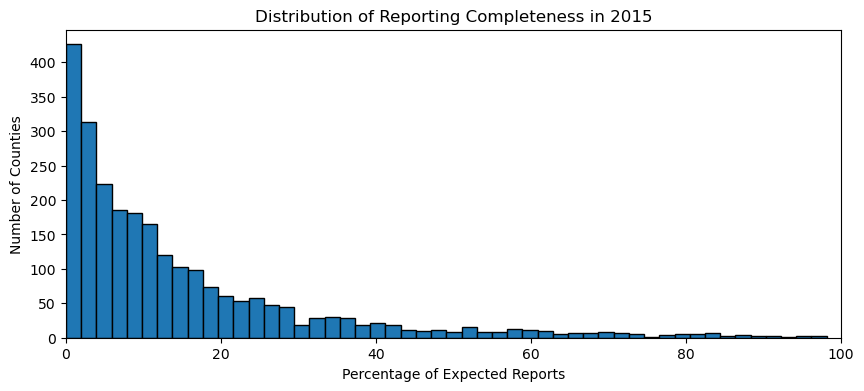

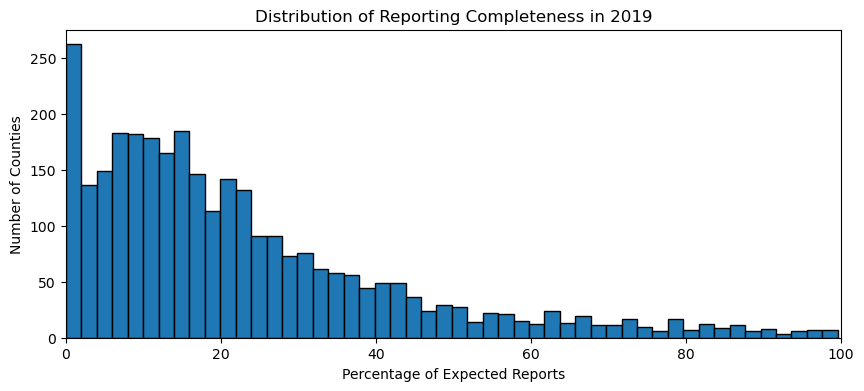

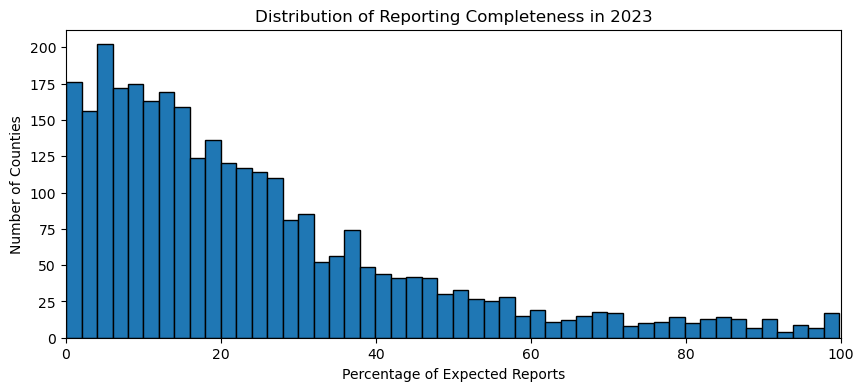

In [7]:
expected_reports = 4 * 24 * 365

plot_reporting_distribution(eaglei_outages_2015, 'run_start_time', expected_reports)
plot_reporting_distribution(eaglei_outages_2019, 'run_start_time', expected_reports)
plot_reporting_distribution(eaglei_outages_2023, 'run_start_time', expected_reports)

Looking at the above summary, we see that a significant number of counties reported less frequently than once every 15 minutes. Since we plan to perform daily aggregation based on the collected weather data (while also considering that the model will have much broader practical applications if it can accurately predict the average number of people losing power in a given day), let's proceed with aggregation by calculating the average and see how this affects the reporting frequency.  

In [43]:
outages_dfs_agg = [aggregate_daily_outages(df) for df in outages_dfs]

In [5]:
outages_dfs_agg[9]

,date,fips_code,county,state,customers_out
0,2023-01-01,1001,Autauga,Alabama,3.827586
1,2023-01-01,1003,Baldwin,Alabama,27.584270
2,2023-01-01,1005,Barbour,Alabama,4.000000
3,2023-01-01,1007,Bibb,Alabama,4.000000
4,2023-01-01,1009,Blount,Alabama,4.000000
...,...,...,...,...,...
870384,2023-12-31,72113,Ponce,Puerto Rico,1710.780000
870385,2023-12-31,72127,San Juan,Puerto Rico,187.687500
870386,2023-12-31,78010,St. Croix,United States Virgin Islands,10.895833
870387,2023-12-31,78020,St. John,United States Virgin Islands,19.266667


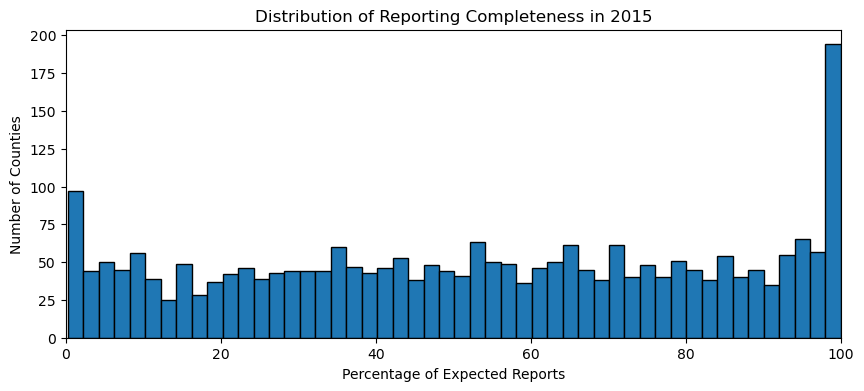

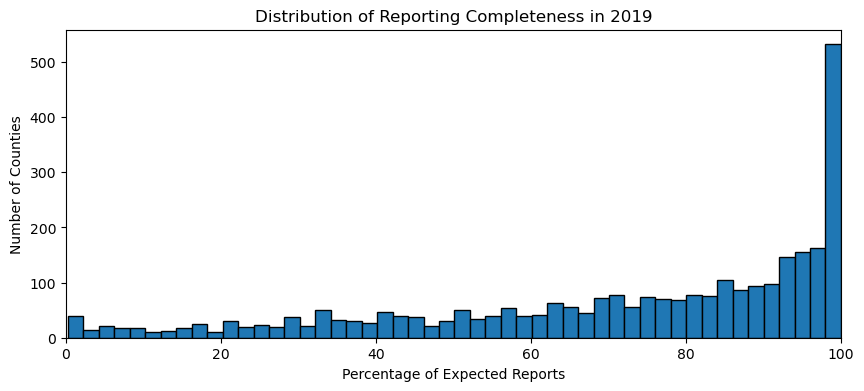

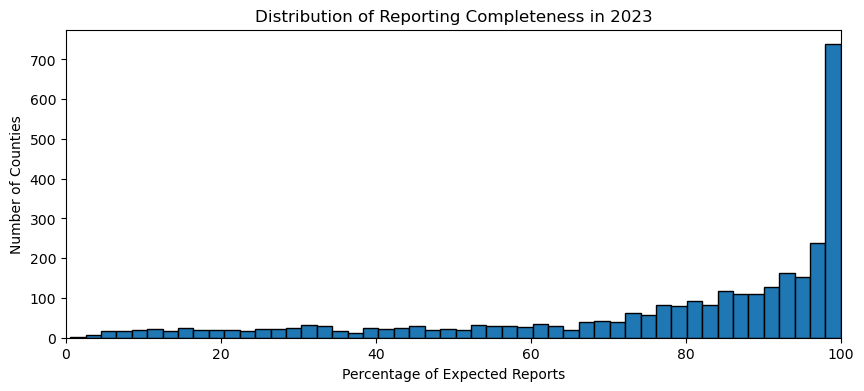

In [10]:
expected_reports = 365

plot_reporting_distribution(outages_dfs_agg[1], 'date', expected_reports)
plot_reporting_distribution(outages_dfs_agg[5], 'date', expected_reports)
plot_reporting_distribution(outages_dfs_agg[9], 'date', expected_reports)

Looking specifically at the final years in the dataset, we observe a striking improvement in data quality. The vast majority of counties report at least once a day. However, there are still some counties that report less frequently than we would expect.  

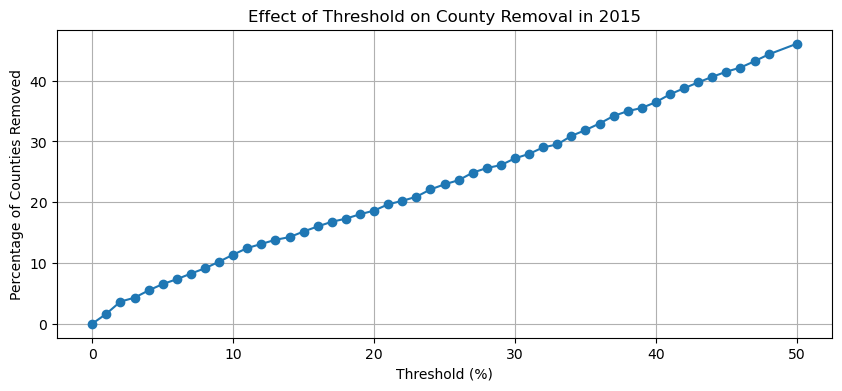

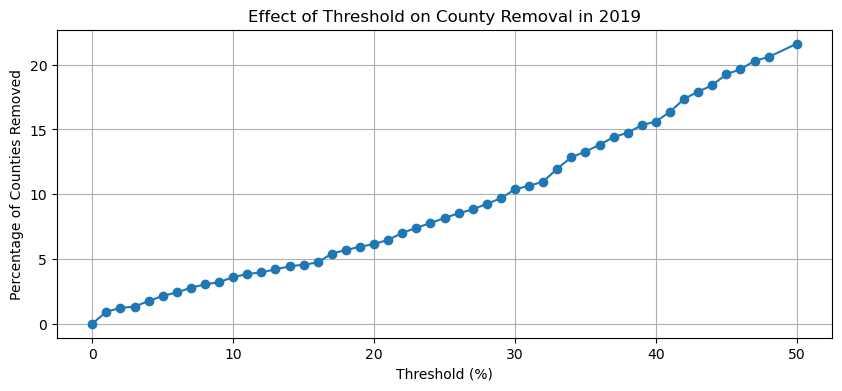

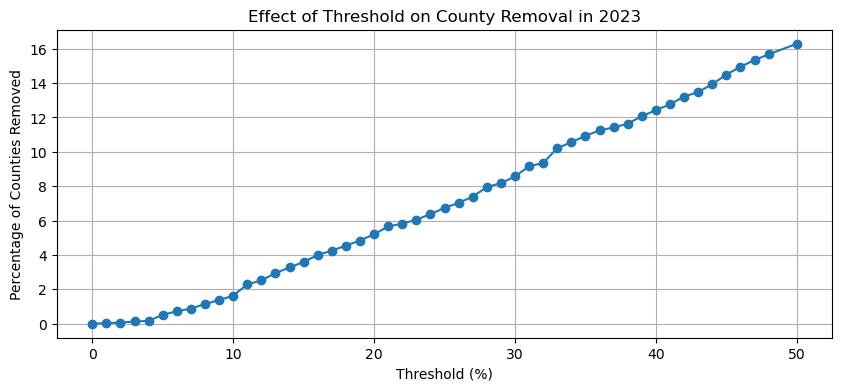

In [11]:
expected_reports = 365
thresholds = np.linspace(0, 50, 50, dtype=int)
plot_removal_effect(outages_dfs_agg[1], 'date', expected_reports, thresholds)
plot_removal_effect(outages_dfs_agg[5], 'date', expected_reports, thresholds)
plot_removal_effect(outages_dfs_agg[9], 'date', expected_reports, thresholds)

After analyzing the data gaps and the number of counties removed in different years, we decide to set the threshold at 30. Counties that reported less frequently in a given year due to their lack of consistency contain low-quality data, and we do not want to include them in the model.

We will exclude data from 2014 as it was only two months and not many counties have had reported then.

In [44]:
outages_dfs_agg.pop(0)

,date,fips_code,county,state,customers_out
0,2014-11-01,1001,Autauga,Alabama,3.000000
1,2014-11-01,1003,Baldwin,Alabama,2.192308
2,2014-11-01,1013,Butler,Alabama,30.611111
3,2014-11-01,1021,Chilton,Alabama,1.000000
4,2014-11-01,1031,Coffee,Alabama,2.000000
...,...,...,...,...,...
70271,2014-12-31,55029,Door,Wisconsin,1.000000
70272,2014-12-31,55079,Milwaukee,Wisconsin,1.000000
70273,2014-12-31,55093,Pierce,Wisconsin,6.000000
70274,2014-12-31,55125,Vilas,Wisconsin,6.000000


In [45]:
expected_reports = 365
outages_dfs_agg_cl = [filter_low_reporting_counties(df, 'date', expected_reports, 30) for df in outages_dfs_agg]

#### U.S. Counties Population and Electricity Access Dataset

We will use new dataset that provides detailed population data by county in the United States. This dataset includes up-to-date information gathered from authoritative sources such as the U.S. Census Bureau and the Bureau of Labor Statistics.

This dataset is based on the freely available data from [SimpleMaps U.S. Counties Dataset](https://simplemaps.com/data/us-counties).

In [46]:
population_data = pd.read_csv('../data/population_data/uscounties.csv')
population_data = population_data[['county_fips', 'population', 'lat', 'lng']]
population_data.loc[:, 'county_fips'] = population_data['county_fips'].astype(str)

Now, we will add an extra column that indicates which data points are more trustworthy—specifically, those with at least 90% completeness over the year. This column will contain a `1` for trustworthy data and a `0` for less complete data.  

Next, we will split the dataset and train a model to determine which approach yields better results. Additionally, we will experiment with different methods for handling missing data. First, we will fill missing values with `0`, assuming that no events occurred during those periods. In the second approach, we will estimate missing values by calculating the mean percentage of people without power in the closest area and multiplying it by the population of each county.  

Finally, we will evaluate which method is more accurate by checking the correlation between the `customers_out` column and events in the StormEvents dataset, as we expect this correlation to be high.

In [47]:
expected_reports = 365
outages_dfs_agg_cl_v1 = [add_valid_data_flag(df, 'date', expected_reports) for df in outages_dfs_agg_cl]

In [48]:
outages_dfs_agg_cl_v2 = [fill_missing_dates(df) for df in outages_dfs_agg_cl_v1]

Based on the provided DataFrame, we create the `percent_customers_out` column (for the few cases where the value of this column exceeds 100%, we replace it with 100).

In [49]:
outages_dfs_agg_cl_v3 = [calculate_percent_customers_out(df, mcc) for df in outages_dfs_agg_cl_v2]

In [50]:
outages_dfs_agg_cl_v4 = [estimate_customers_out(df, mcc) for df in outages_dfs_agg_cl_v3]

Using the population data, we added the 'lat' and 'lng' columns, which contain the geographical coordinates (latitude and longitude) of the counties.

In [51]:
outages_dfs_agg_geo = [addGeo(df, population_data[['county_fips', 'lat', 'lng']]) for df in outages_dfs_agg_cl_v4]

In [52]:
outages_final = combine_dfs(outages_dfs_agg_geo)

In [53]:
outages_final

,fips_code,date,county,state,valid_data_flag,customers_out,percent_customers_out,customers_out_estimate,county_fips,lat,lng
0,1021,2015-01-01,Chilton,Alabama,0,3.000000,0.015453,3.000000,1021,32.8479,-86.7188
1,1021,2015-01-02,Chilton,Alabama,0,13.375000,0.068894,13.375000,1021,32.8479,-86.7188
2,1021,2015-01-03,Chilton,Alabama,0,0.000000,0.000000,3.920775,1021,32.8479,-86.7188
3,1021,2015-01-04,Chilton,Alabama,0,39.333333,0.202603,39.333333,1021,32.8479,-86.7188
4,1021,2015-01-05,Chilton,Alabama,0,0.000000,0.000000,9.191099,1021,32.8479,-86.7188
...,...,...,...,...,...,...,...,...,...,...,...
8058005,47027,2023-12-27,Clay,Tennessee,0,3.000000,0.073983,3.000000,47027,36.5511,-85.5439
8058006,47027,2023-12-28,Clay,Tennessee,0,3.000000,0.073983,3.000000,47027,36.5511,-85.5439
8058007,47027,2023-12-29,Clay,Tennessee,0,0.000000,0.000000,6.475987,47027,36.5511,-85.5439
8058008,47027,2023-12-30,Clay,Tennessee,0,0.000000,0.000000,11.892883,47027,36.5511,-85.5439


In [54]:
outages_final.to_csv('../data/modelingData/outages_final.csv', index=False)

#### **Summary of the Final DataFrame**

The final DataFrame represents an aggregation of daily data with the following key columns:

1. **fips_code**: A unique identifier for each county.
2. **date**: The specific date of the record.
3. **county**: The name of the county.
4. **state**: The state to which the county belongs.
5. **valid_data_flag**: A flag indicating the quality of the data, where:
   - **1**: Represents counties reporting data for at least 90% of the days in the year.
   - **0**: Represents counties with less frequent data reporting.
6. **customers_out**: The original column showing the number of customers without power. This value has been supplemented with zeros for records that were missing.
7. **percent_customers_out**: The percentage of customers without power, calculated using data from the `MCC.csv` file.
8. **customers_out_estimate**: This column estimates the `customers_out` for records where the value was zero. The estimate is calculated by taking the average percentage of customers without power in the respective county and multiplying it by the total number of customers in that county.
9. **lat**: The latitude of the county, representing the geographical location, from the 'uscounties.csv' file.
10. **lng**: The longitude of the county, representing the geographical location,from the 'uscounties.csv' file.

It's important to note that this is not the final dataset we will use for modeling. The features selected for modeling will be determined during the later stages of feature engineering. 

This dataset serves as a foundational step in preparing and enriching the data for future analysis and modeling.

__________________________________________________________________________________

## NOAA_StormEvents

When preparing the NOAA Storm Events dataset for modeling, we carefully evaluated each column based on its relevance, interpretability, and potential predictive power.

### Columns Removed and Justification  

When preparing the dataset for analysis and modeling, we decided to remove certain columns that were redundant, had excessive missing values, or lacked predictive value. Below is a summary of our choices and reasoning:  

### Redundant Date & Time Columns  
These columns are unnecessary because we already have a comprehensive timestamp (`BEGIN_DATE_TIME`):  
- **BEGIN_YEARMONTH, BEGIN_DAY, BEGIN_TIME, YEAR, MONTH_NAME** – All information is contained within `BEGIN_DATE_TIME`.  
- **END_YEARMONTH, END_DAY, END_TIME, END_DATE_TIME** – In many cases, they mirror the corresponding "BEGIN" values.  

###  Identifiers with No Predictive Value  
These columns serve as unique identifiers but do not provide useful information for predictions:  
- **EPISODE_ID, EVENT_ID**  

###  Location and Metadata Redundancies  
These columns do not add meaningful information beyond what is already available in latitude, longitude, and other geographical data:  
- **WFO** – A regional code that does not provide direct weather-related insights.  
- **CZ_TIMEZONE** – We already have latitude, longitude, and time information.  
- **BEGIN_LOCATION / END_LOCATION** – We have precise latitude and longitude coordinates, making these redundant.  
- **END_LAT / END_LON** – In 50% cases, these values are identical to `BEGIN_LAT` and `BEGIN_LON`.  

###  Columns with Too Many Missing Values     
These columns have excessive missing values
- **MAGNITUDE / MAGNITUDE_TYPE** – Insufficient data coverage.  
- **FLOOD_CAUSE** 
- **TOR_F_SCALE, TOR_LENGTH, TOR_WIDTH** – Only applicable to tornadoes, and missing for all other event types.  
- **TOR_OTHER_WFO, TOR_OTHER_CZ_STATE, TOR_OTHER_CZ_FIPS, TOR_OTHER_CZ_NAME** 

###  Text-Based Columns (Not Used in Our Approach)  
These columns contain long text narratives, which we are not using since we are not applying NLP models:  
- **EPISODE_NARRATIVE, EVENT_NARRATIVE** 

###  Other Irrelevant Columns  
- **DATA_SOURCE** – Contains only one unique value, providing no useful information.  
- **SOURCE** – Lacks a clear predictive role 

In [5]:
summarize_overall_missing(stormEvents_dfs)

,DATASET,MISSING_MAGNITUDE,PRESENT_MAGNITUDE,MISSING_PERCENT
0,stormEvents_2014,29969,29506,50.39
1,stormEvents_2015,29273,28634,50.55
2,stormEvents_2016,24661,31344,44.03
3,stormEvents_2017,23330,33699,40.91
4,stormEvents_2018,34063,28634,54.33
5,stormEvents_2019,32244,35617,47.51
6,stormEvents_2020,26418,34861,43.11
7,stormEvents_2021,31333,30056,51.04
8,stormEvents_2022,36148,33738,51.72
9,stormEvents_2023,35327,40269,46.73


In [5]:
stormEvents_events_col = [create_event_columns(df) for df in stormEvents_dfs]

% of rows whre BEGIN_LAT = BEGIN_LON

In [8]:
equal_percent = (stormEvents_2015["BEGIN_LON"] == stormEvents_2015["END_LON"]).mean() * 100

print(f"% rows, where BEGIN_LAT = BEGIN_LON: {equal_percent:.2f}%")

% rows, where BEGIN_LAT = BEGIN_LON: 46.17%


% of rows wheree END_AZIMUTH does not have value

In [14]:
missing_percent = stormEvents_2015["END_AZIMUTH"].isna().mean() * 100

print(f"% rows without value in END_AZIMUTH: {missing_percent:.2f}%")

% rows without value in END_AZIMUTH: 35.61%


### New Features  

1. **Category Column**  
   - We will use one-hot encoding to represent different types of catastrophes as separate features.  

2. **Creating New Columns**  
   - **`total_damages`** = `DAMAGE_PROPERTY` + `DAMAGE_CROPS`  
   - **`total_people_injuries`** = `DEATHS_DIRECT` + `DEATHS_INDIRECT` + `INJURIES_DIRECT` + `INJURIES_INDIRECT`  
   - **`percent_of_deaths`** = (`DEATHS_DIRECT` + `DEATHS_INDIRECT`) / `total_people_injuries`  

Columns MAGNITUDE, CATEGORY, and TOR_F_SCALE represent event intensity. 

To unify this data into a single MAGNITUDE column, we first convert TOR_F_SCALE (tornado intensity) into numerical values, handling unknown EFU values by replacing them with state-based medians. 

Missing MAGNITUDE values are then filled using CATEGORY and, if necessary, TOR_F_SCALE.

We implemented a similar approach to one-hot encoding: for events without intensity data, we use one-hot encoding (assigning a 1 for the corresponding event). For events with intensity data, we replace the 1 in the event's column with the value from the MAGNITUDE column.

In [26]:
stormEvents_events_col = [create_event_columns(df) for df in stormEvents_dfs]

Columns DAMAGE_PROPERTY and DAMAGE_CROPS first have to be transformed into floats then they are used to create new column total_damages.
From other damege columns we create: columns total_people_injuries and percent_of_deaths

In [27]:
stormEvents_damages = [convert_damage_property(df) for df in stormEvents_events_col]

In [28]:
stormEvents_new_col = [process_storm_events(df) for df in stormEvents_damages]

### New seasonal / geographical features

Our next idea was to create colums that represent some point in time - year season and time during the day. We wanted to check whether there are some meaningful correlations and dependencies between those columns and power outages and weather catastrophies. It could be valid information eg. if power outages occur more in summer than in winter

In [68]:
def get_season(date):
    month = date.month
    day = date.day
    if (month == 3 and day >= 21) or month in [4, 5] or (month == 6 and day < 21):
        return 'Spring'
    elif (month == 6 and day >= 21) or month in [7, 8] or (month == 9 and day < 23):
        return 'Summer'
    elif (month == 9 and day >= 23) or month in [10, 11] or (month == 12 and day < 21):
        return 'Fall'
    else:
        return 'Winter'
    
def get_day(date):
    hour = date.hour
    if hour < 6:
        return 'Night'
    elif hour < 12:
        return 'Morning'
    elif hour < 18:
        return 'Afternoon'
    else:
        return 'Evening'

In [7]:
for df in outages_dfs:
    df['run_start_time'] = pd.to_datetime(df['run_start_time'])
    df['season'] = df['run_start_time'].apply(get_season)

for df in stormEvents_dfs:
    df['BEGIN_DATE_TIME'] = pd.to_datetime(df['BEGIN_DATE_TIME'])
    df['season'] = df['BEGIN_DATE_TIME'].apply(get_season)

C:\Users\HP\AppData\Local\Temp\ipykernel_23636\2558229184.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['BEGIN_DATE_TIME'] = pd.to_datetime(df['BEGIN_DATE_TIME'])
C:\Users\HP\AppData\Local\Temp\ipykernel_23636\2558229184.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['BEGIN_DATE_TIME'] = pd.to_datetime(df['BEGIN_DATE_TIME'])
C:\Users\HP\AppData\Local\Temp\ipykernel_23636\2558229184.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['BEGIN_DATE_TIME'] = pd.to_datetime(df['BEGIN_DATE_TIME'])
C:\Users\HP\AppData\Local\Temp\ipykernel_23636\2558229184.py:6: 

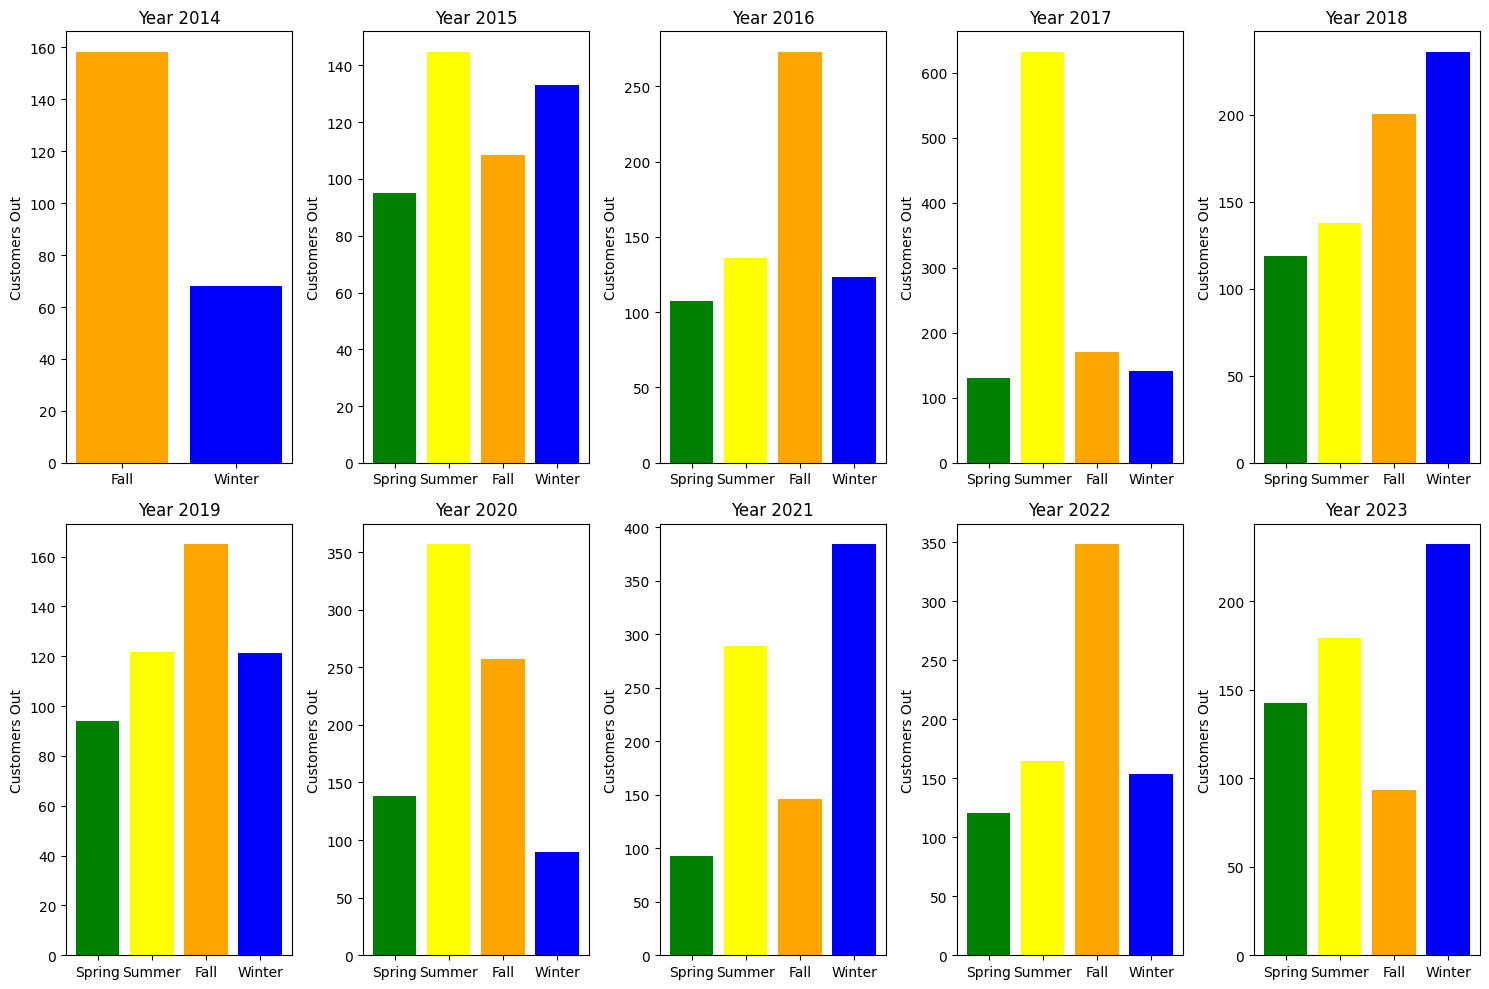

In [ ]:
plot_seasonal_data(outages_dfs, 'season_customer', 'Customers Out')

There is no pattern in this data. Every year is different and there are no similarities between the years.

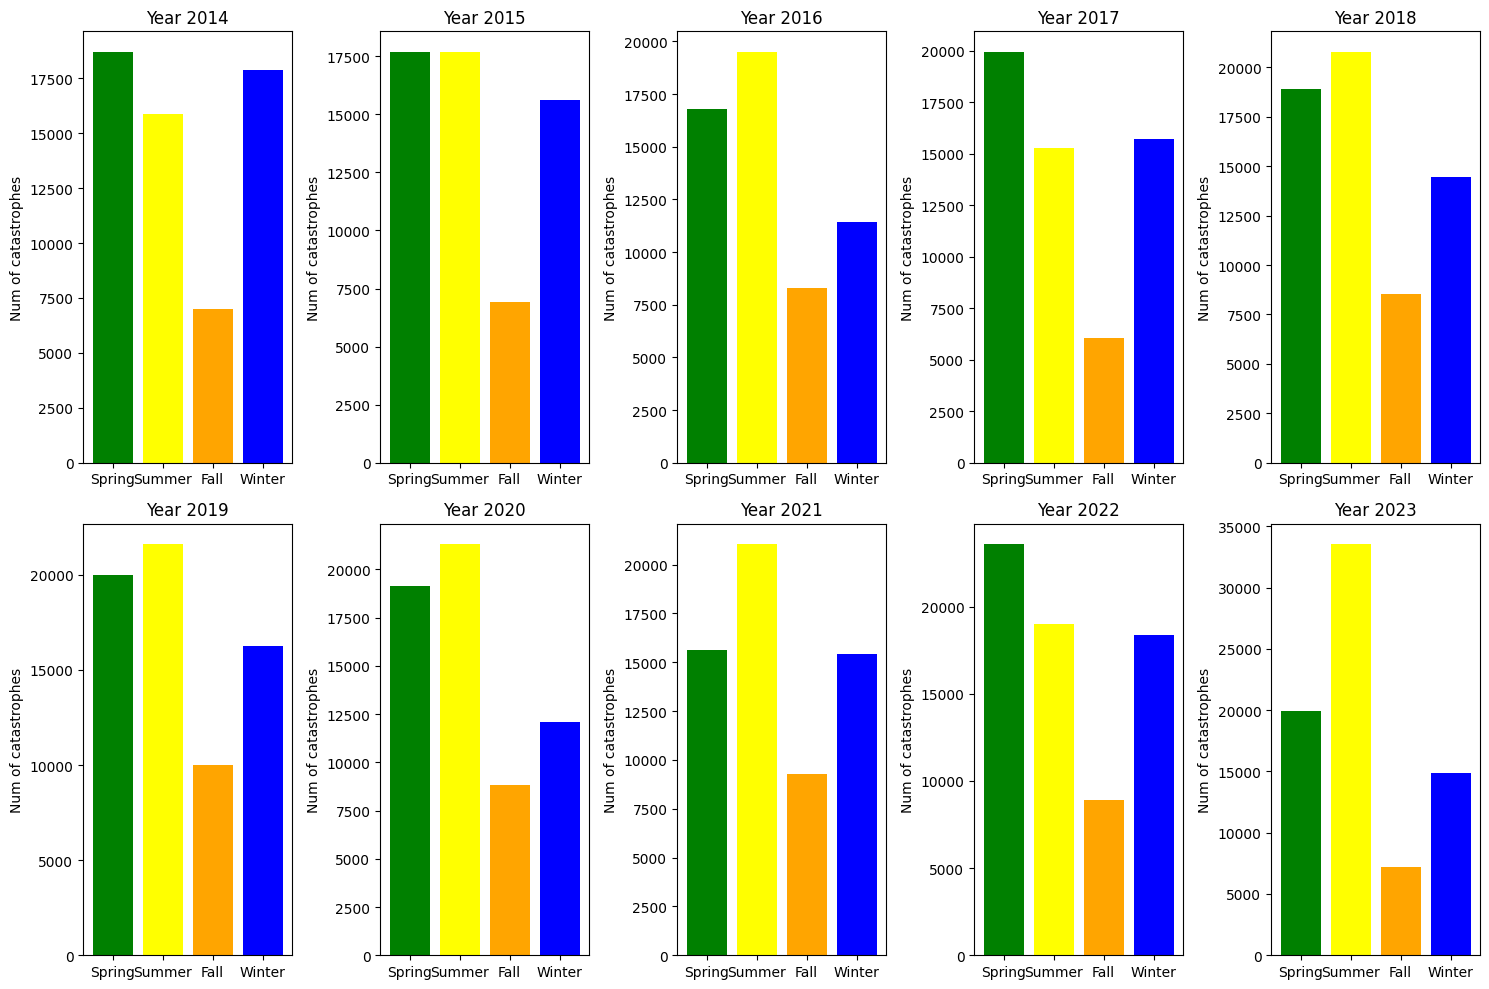

In [ ]:
plot_seasonal_data(stormEvents_dfs, 'season_catastrophes', 'Num of catastrophes')


here we can see that the smallest number of catastrophes happens in fall, while in spring and summer those numbers are higher

In [30]:
for df in outages_dfs:
    df['daytime'] = df['run_start_time'].apply(get_day)
for df in stormEvents_dfs:
    df['daytime'] = df['BEGIN_DATE_TIME'].apply(get_day)

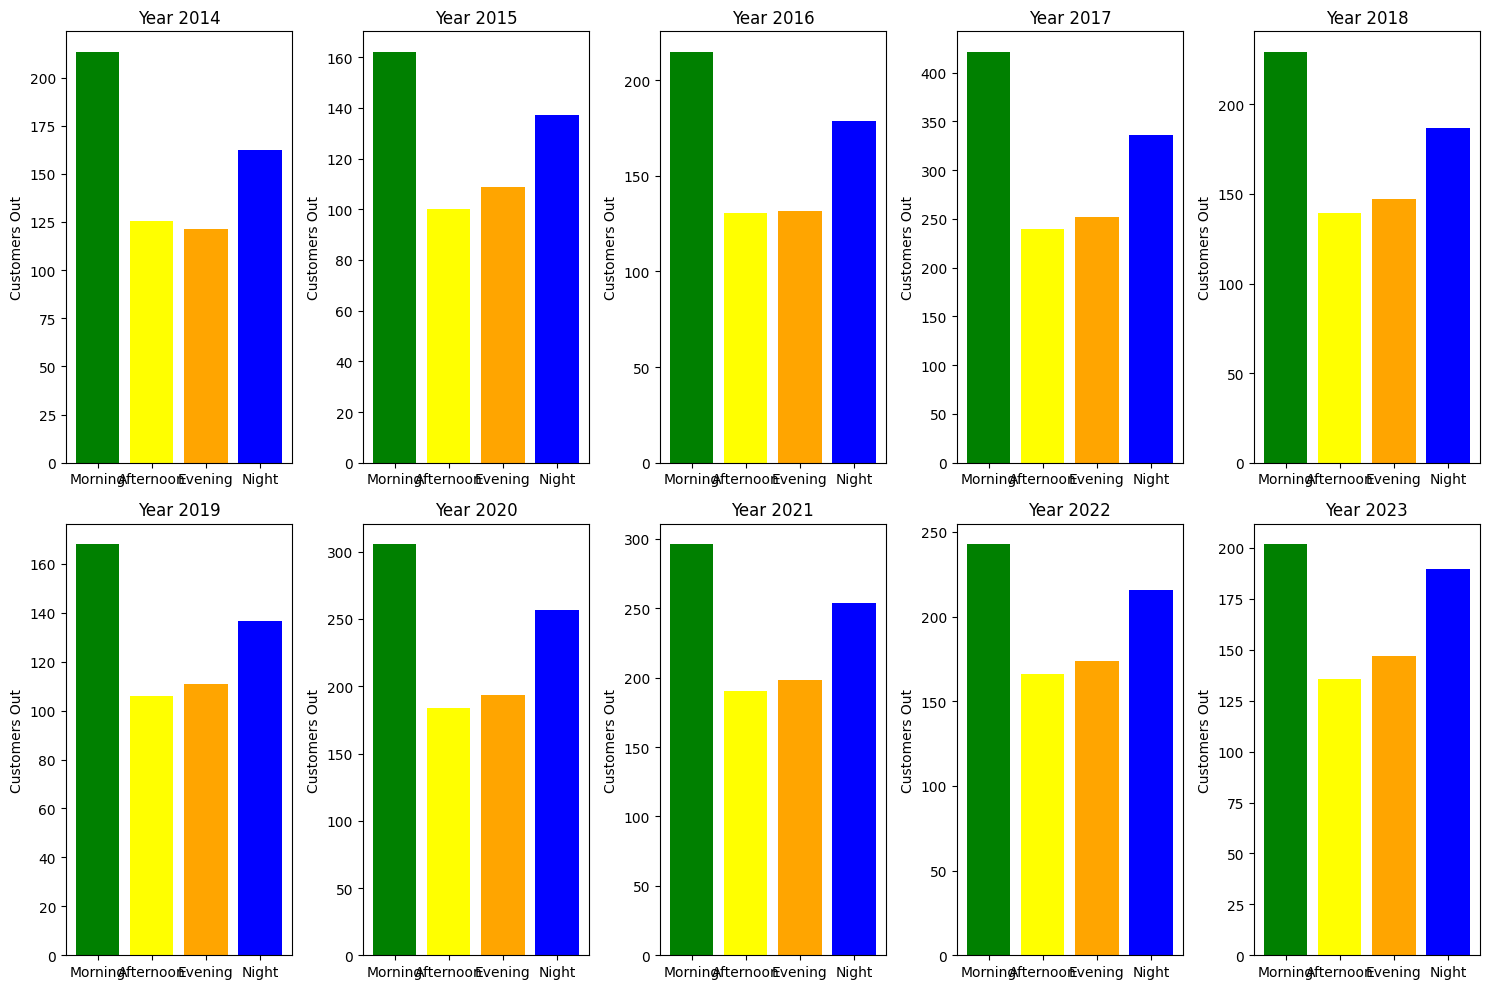

In [44]:
plot_seasonal_data(outages_dfs, 'daytime_customer', 'Customers Out')

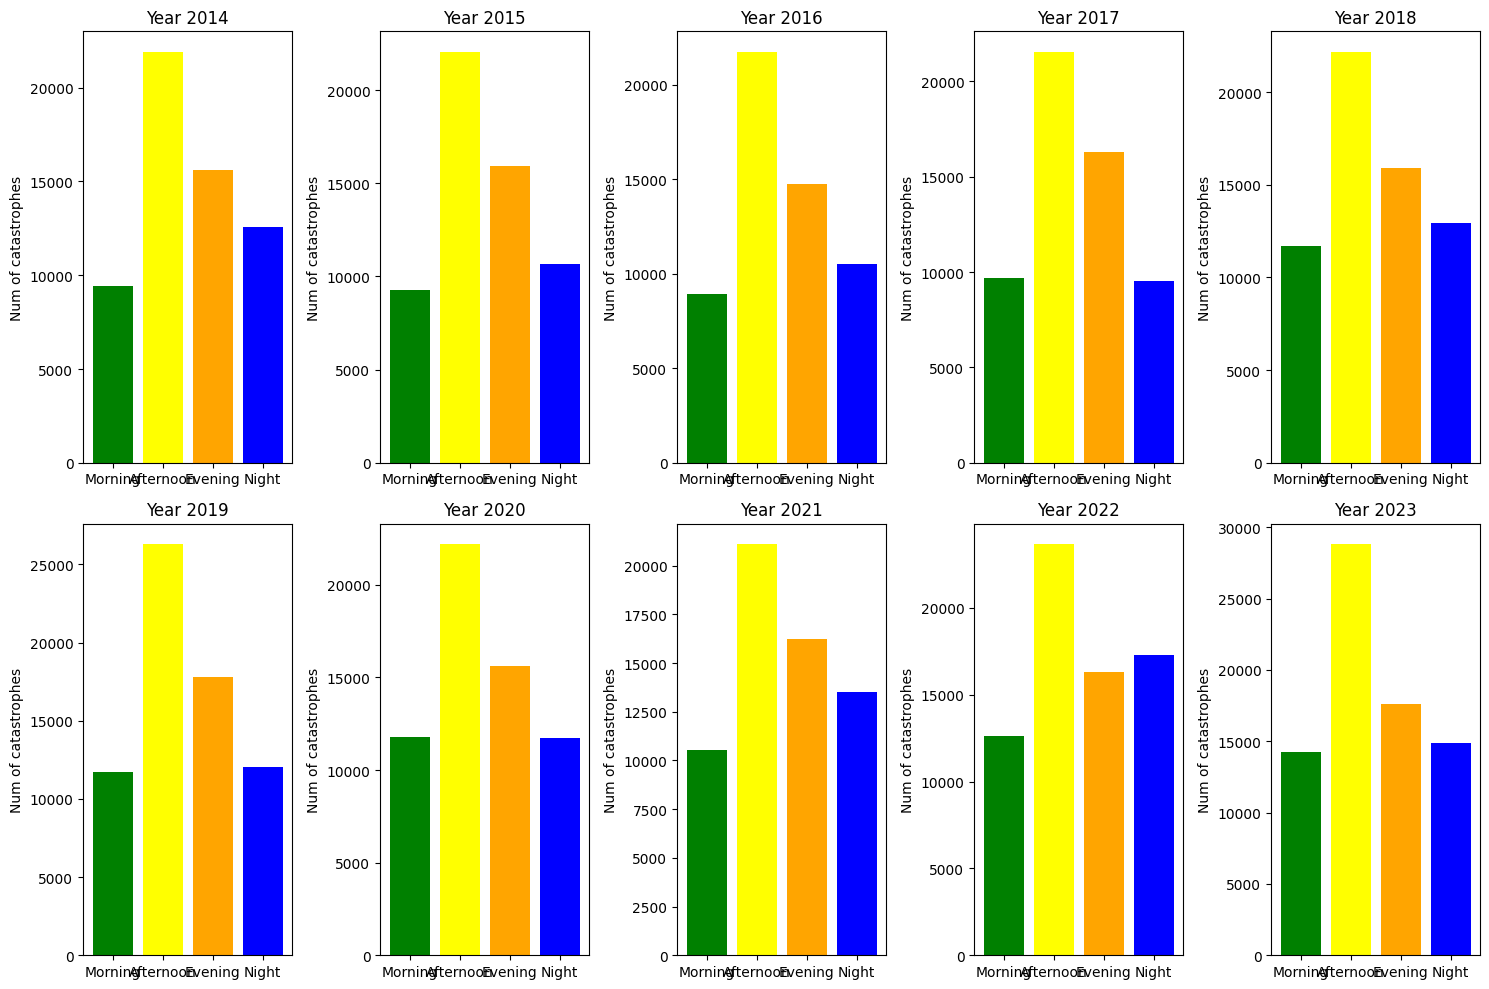

In [ ]:
plot_seasonal_data(stormEvents_dfs, 'daytime_catastrophes', 'Num of catastrophes')

We can see that the biggest number of catastrophes happen in the afternoon, while the smallest in the morning

We can see that both catastrophes and power outages have a correlation with a particular part of the day. If we decide to group our data by hour, then this column might be useful. Seasons do not seem as important as daytime - there is not pattern in data and the number of customers_out in particular seasons changes over the years.

Now we will try to find the connection between power outages and regions in the USA. There are 9 main regions

In [64]:
regions = pd.read_csv("../data/states_data/states.csv")

In [14]:
for i in range(len(outages_dfs)):
    outages_dfs[i] = pd.merge(outages_dfs[i], regions, left_on='state', right_on='State', how = 'left')

In [16]:
outages_dfs[1].head()

,fips_code,county,state,customers_out,run_start_time,State,State Code,Region,Division
0,1021,Chilton,Alabama,3,2015-01-01 00:00:00,Alabama,AL,South,East South Central
1,5003,Ashley,Arkansas,3,2015-01-01 00:00:00,Arkansas,AR,South,West South Central
2,5023,Cleburne,Arkansas,1,2015-01-01 00:00:00,Arkansas,AR,South,West South Central
3,5085,Lonoke,Arkansas,2,2015-01-01 00:00:00,Arkansas,AR,South,West South Central
4,5107,Phillips,Arkansas,3,2015-01-01 00:00:00,Arkansas,AR,South,West South Central


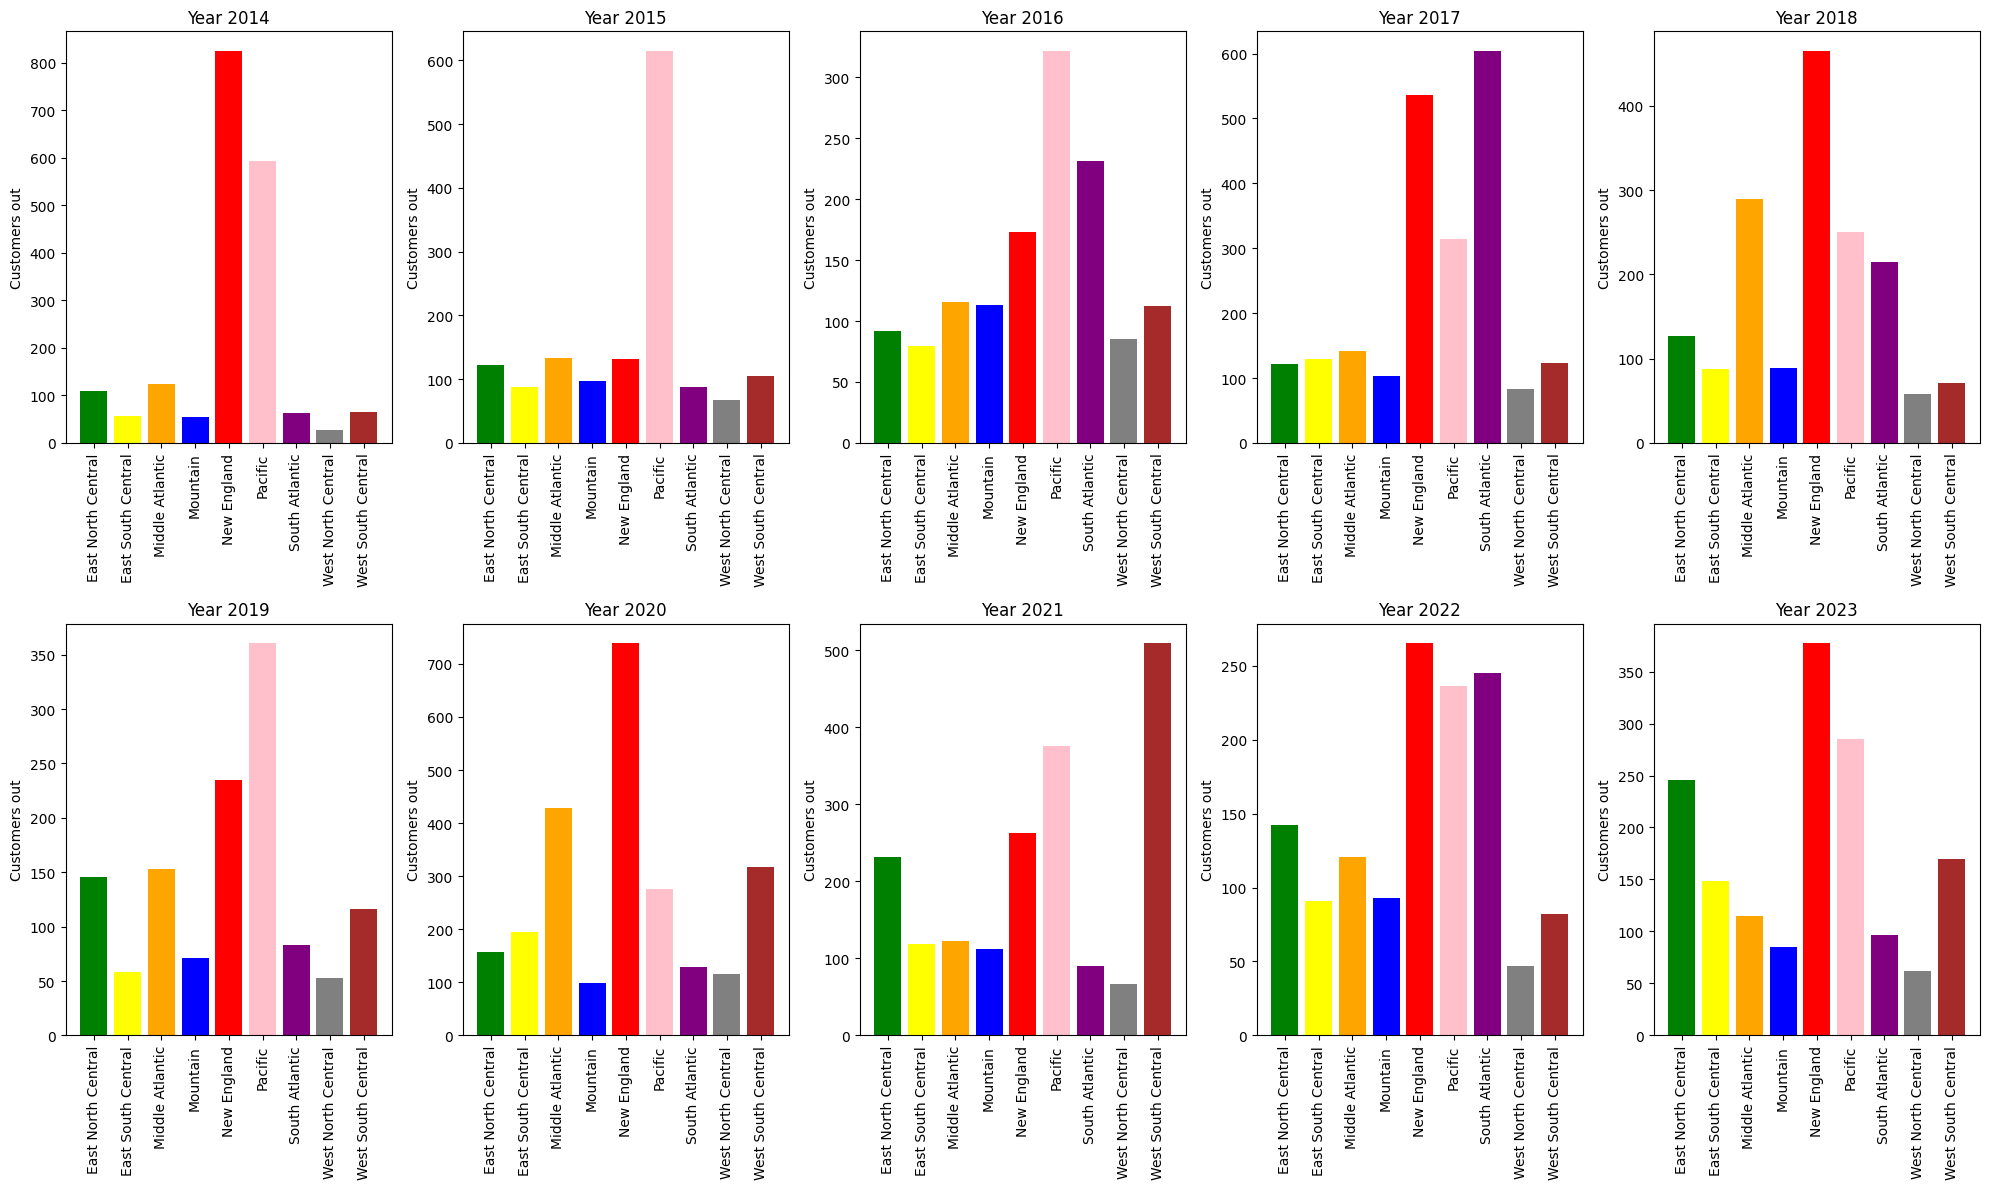

In [ ]:
plot(outages_dfs, 'column', 'Customers out')

From the visualization above, we can observe that the largest outages occur in the New England and Pacific regions. This trend is consistent across almost every year. Additionally, the Middle Atlantic region experiences significant outages in certain years. Since these regions are located along the east and west coasts, we can conclude that proximity to the ocean plays a significant role, as coastal areas tend to experience more severe outages.

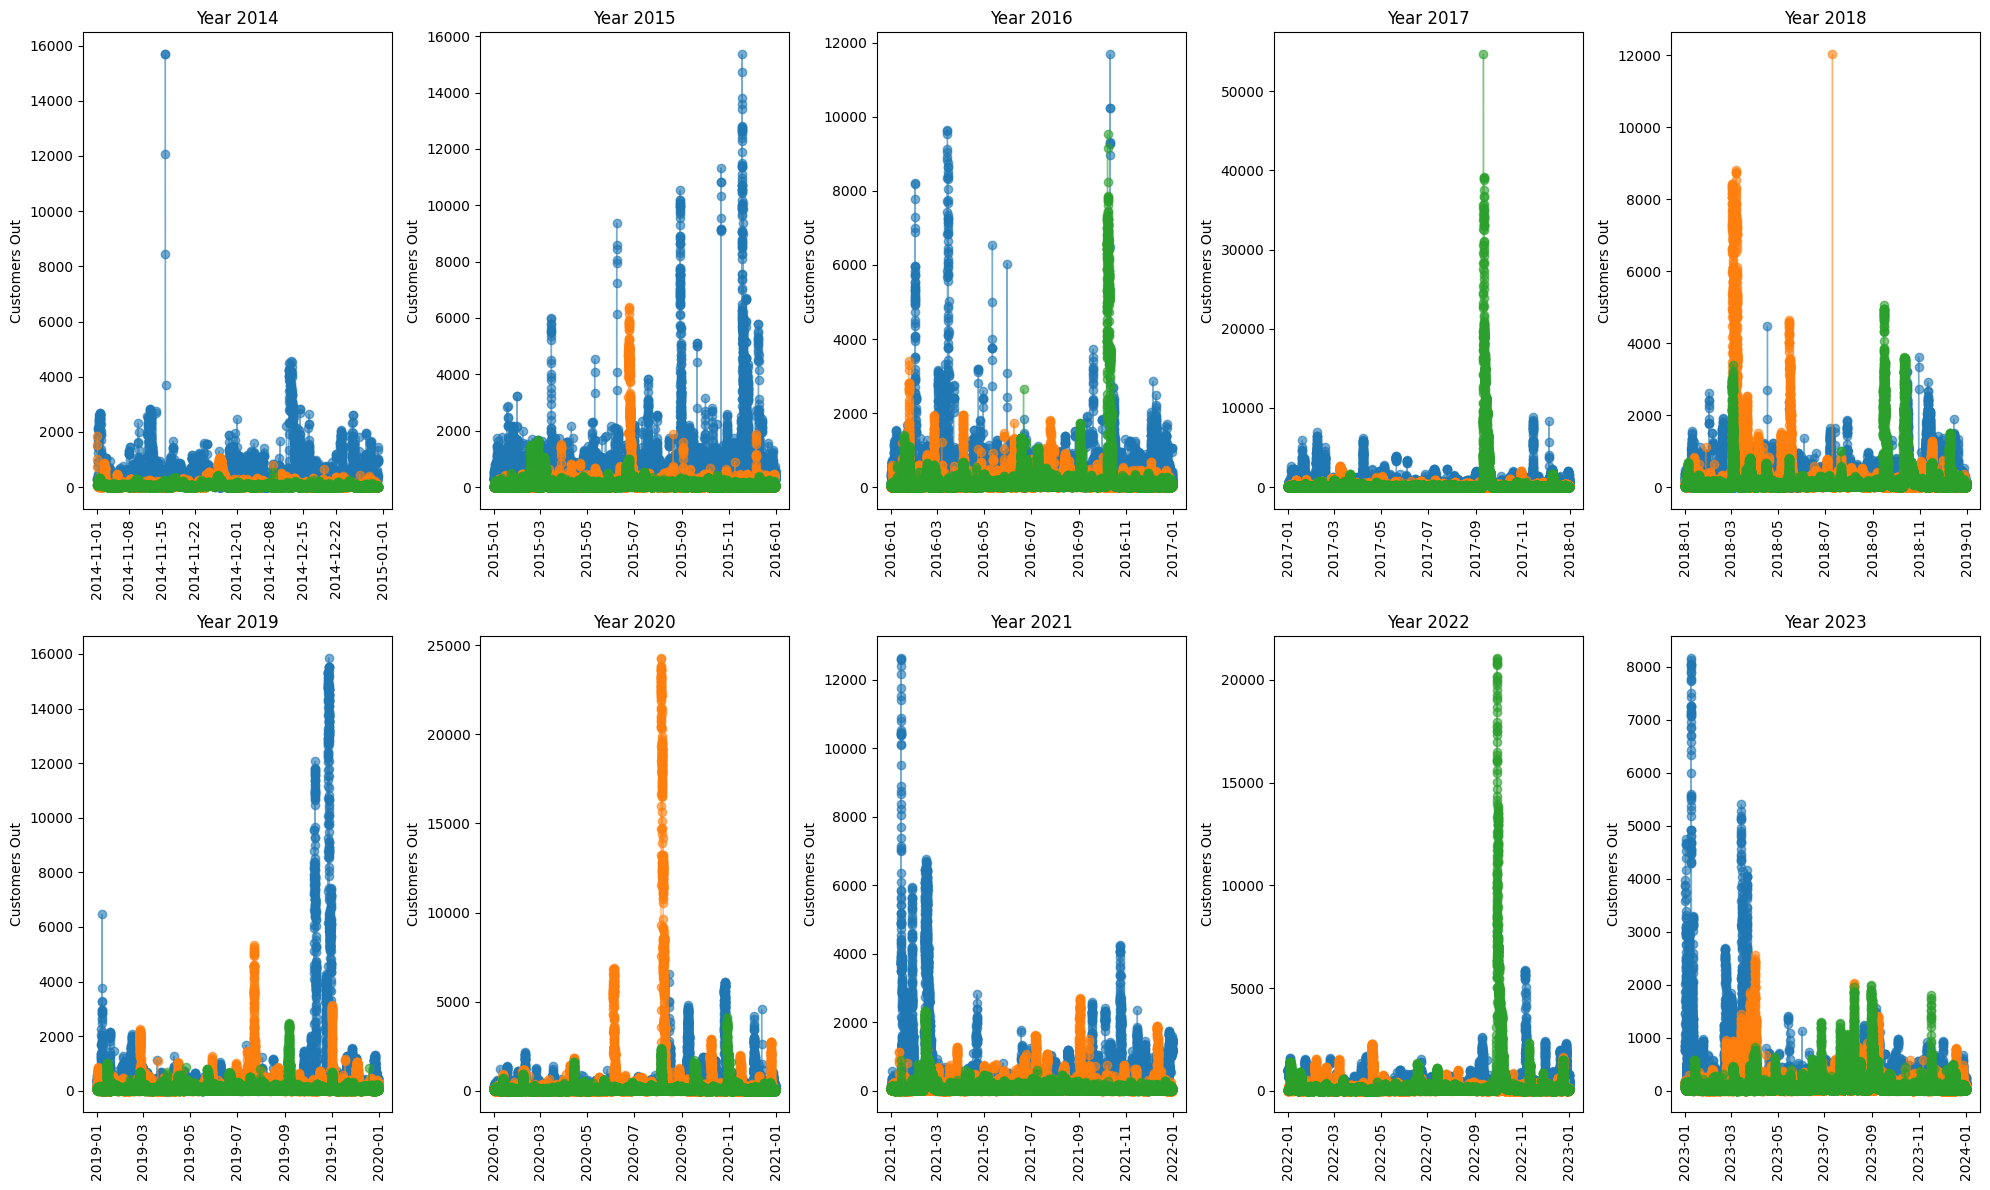

In [ ]:
plot(outages_dfs, 'timedata', 'Customers Out')

__________________________________________________________________________________

# Final Merge

In [29]:
df_copy = copy.deepcopy(stormEvents_new_col)

In [30]:
common_cols = set(df_copy[0].columns)
for df in df_copy[1:]:
    common_cols &= set(df.columns)

stormEvents_cleaned = [df[list(common_cols)] for df in df_copy]

In [31]:
stormEvents_cleaned[0].columns

Index(['BEGIN_LON', 'Astronomical Low Tide', 'Dense Fog', 'Drought',
       'EVENT_NARRATIVE', 'CZ_FIPS', 'Lake-Effect Snow', 'BEGIN_YEARMONTH',
       'Wildfire', 'Marine Strong Wind', 'BEGIN_DAY', 'END_DATE_TIME',
       'total_damages', 'Coastal Flood', 'TOR_OTHER_CZ_FIPS', 'MAGNITUDE_TYPE',
       'END_YEARMONTH', 'EPISODE_NARRATIVE', 'EVENT_TYPE',
       'TOR_OTHER_CZ_STATE', 'Sneakerwave', 'Marine High Wind',
       'Thunderstorm Wind', 'Freezing Fog', 'STATE', 'Flood', 'TOR_LENGTH',
       'Dust Storm', 'END_TIME', 'Frost/Freeze', 'EPISODE_ID', 'Heavy Snow',
       'Storm Surge/Tide', 'Winter Storm', 'total_people_injuries',
       'Winter Weather', 'BEGIN_AZIMUTH', 'CZ_NAME', 'Ice Storm',
       'TOR_OTHER_WFO', 'Excessive Heat', 'Tropical Storm', 'Rip Current',
       'Marine Hail', 'Tornado', 'Sleet', 'Avalanche', 'percent_of_deaths',
       'Waterspout', 'SOURCE', 'END_LOCATION', 'Marine Thunderstorm Wind',
       'EVENT_ID', 'TOR_OTHER_CZ_NAME', 'Extreme Cold/Wind Chill',
 

In [32]:
stormEvents_cleaned = [
    df[['Astronomical Low Tide', 'Extreme Cold/Wind Chill', 'Flood', 'Winter Weather',
        'STATE', 'total_damages', 'Wildfire', 'Heavy Rain', 'Cold/Wind Chill', 'Dense Fog',
        'Marine Thunderstorm Wind', 'Frost/Freeze', 'Sneakerwave',
        'Strong Wind', 'Lake-Effect Snow', 'Funnel Cloud', 'Flash Flood', 'Heavy Snow',
        'Ice Storm', 'Thunderstorm Wind', 'Avalanche', 'CZ_NAME', 'Excessive Heat',
        'Coastal Flood', 'Storm Surge/Tide', 'Sleet', 'Marine Hail', 'Debris Flow',
        'Winter Storm', 'total_people_injuries', 'MAGNITUDE', 'Tropical Storm',
        'Waterspout', 'Dust Storm', 'Drought', 'percent_of_deaths', 'Blizzard',
        'Marine Strong Wind', 'Lightning', 'Tornado', 'Hail', 'Rip Current', 'Heat',
        'BEGIN_DATE_TIME', 'Marine High Wind', 'Freezing Fog', 'High Surf', 'High Wind']]
    for df in stormEvents_cleaned
]

In [162]:
stormEvents_grouped = []

for df in stormEvents_cleaned:
    df['BEGIN_DATE_TIME'] = pd.to_datetime(df['BEGIN_DATE_TIME']).dt.date

    grouped = df.groupby(['STATE', 'BEGIN_DATE_TIME', 'CZ_NAME']).max(numeric_only=True).reset_index()

    stormEvents_grouped.append(grouped)

In [164]:
all_grouped = pd.concat(stormEvents_grouped, ignore_index=True)
all_grouped = all_grouped.drop(columns=['STATE'])
all_grouped['BEGIN_DATE_TIME'] = pd.to_datetime(all_grouped['BEGIN_DATE_TIME']).dt.date

In [165]:
df_customers_out = pd.read_csv("../data/modelingData/outages_final.csv")
df_customers_out['county'] = df_customers_out['county'].str.upper()
df_customers_out['date'] = pd.to_datetime(df_customers_out['date']).dt.date

In [ ]:
df_merged = pd.merge(df_customers_out, all_grouped, left_on=['date', 'county'], 
                     right_on=['BEGIN_DATE_TIME', 'CZ_NAME'], how='left').fillna(0)
df_merged = df_merged.drop(columns=['BEGIN_DATE_TIME', 'CZ_NAME'])

In [ ]:
regions['State'] = regions['State'].str.capitalize()
df_with_regions = pd.merge(df_merged, regions, left_on='state', right_on='State', how ='left')
df_with_regions = df_with_regions.drop(columns=['State', 'State Code'])
df_with_regions['season'] = df_with_regions['date'].apply(get_season)


In [ ]:
weather_data = load_data('../data/weather_data/weather_data.csv')
df_with_regions['date'] = pd.to_datetime(df_with_regions['date'])
df_with_regions['fips_code'] = df_with_regions['fips_code'].astype(str)
df_with_regions['fips_code'] = df_with_regions['fips_code'].astype(str).str.zfill(5)
weather_data['fips'] = weather_data['fips'].astype(str)

In [225]:
final_merge = pd.merge(df_with_regions, weather_data, left_on=['date', 'fips_code'], right_on=['date', 'fips'], how = 'left')

#### Merge Check
Below are the codes designed to check the quality of our data and verify whether the integration of all sources has introduced any errors, and if so, to correct them.

In [226]:
final_merge = final_merge.drop(['st_abb', 'st_code', 'county_name', 'fips', 'stability', 'county_fips', 
                                'year', 'month', 'day'], axis=1)
final_merge = final_merge.drop(['Marine Thunderstorm Wind', 'Sneakerwave', 'Marine Hail', 'Waterspout', 
                                'Marine Strong Wind', 'Marine High Wind'], axis=1)
final_merge['county'] = final_merge['county'].str.capitalize()
final_merge = final_merge.rename(columns={
    'fips_code': 'Fips',
    'date': 'Date',
    'county': 'CountyName',
    'state': 'StateName',
    'valid_data_flag': 'ValidDataFlag',
    'customers_out' : 'CustomersOut',
    'percent_customers_out' : 'PercentCustomersOut',
    'customers_out_estimate' : 'CustomersOutEstimate',
    'lat' : 'Lat',
    'lng' : 'Lng',
    'season' : 'Season',
    'MAGNITUDE' : 'Magnitude',
    'total_damages' : 'TotalDamages',
    'total_people_injuries' : 'TotalPeopleInjuries',
    'tmin': 'Tmin',
    'tmax' : 'Tmax',
    'tavg' : 'Tavg',
    'ppt' : 'Ppt',
    'year' : 'Year',
    'month' : 'Month',
    'day' : 'Day'
})

In [206]:
missing_summary = pd.DataFrame({
    'missing_count': final_merge.isnull().sum(),
    'missing_percent': final_merge.isnull().mean() * 100
})

In [207]:
missing_summary[missing_summary['missing_count'] > 0]

,missing_count,missing_percent
Region,1264584,15.192138
Division,1264584,15.192138
Tmin,34326,0.412377
Tmax,34326,0.412377
Tavg,34326,0.412377
Ppt,34326,0.412377


In [227]:
final_merge['Region'] = final_merge['Region'].fillna('Other')
final_merge['Division'] = final_merge['Division'].fillna('Other')

In [221]:
nan_count_per_county = final_merge.groupby('Division')['Ppt'] \
    .apply(lambda x: x.isna().sum())
nan_count_per_county[nan_count_per_county > 0]

Division
Pacific    18623
Name: Ppt, dtype: int64

In [228]:
final_merge['Year'] = final_merge['Date'].dt.year
final_merge['Month'] = final_merge['Date'].dt.month

In [229]:
final_merge['Tmin'] = final_merge.groupby(['Region', 'Month'])['Tmin'].transform(lambda x: x.fillna(x.mean()))
final_merge['Tmax'] = final_merge.groupby(['Region', 'Month'])['Tmax'].transform(lambda x: x.fillna(x.mean()))
final_merge['Tavg'] = final_merge.groupby(['Region', 'Month'])['Tavg'].transform(lambda x: x.fillna(x.mean()))
final_merge['Ppt'] = final_merge.groupby(['Region', 'Month'])['Ppt'].transform(lambda x: x.fillna(x.mean()))

In [214]:
final_merge.columns

Index(['Fips', 'Date', 'CountyName', 'StateName', 'ValidDataFlag',
       'CustomersOut', 'PercentCustomersOut', 'CustomersOutEstimate', 'Lat',
       'Lng', 'Astronomical Low Tide', 'Extreme Cold/Wind Chill', 'Flood',
       'Winter Weather', 'TotalDamages', 'Wildfire', 'Heavy Rain',
       'Cold/Wind Chill', 'Dense Fog', 'Frost/Freeze', 'Strong Wind',
       'Lake-Effect Snow', 'Funnel Cloud', 'Flash Flood', 'Heavy Snow',
       'Ice Storm', 'Thunderstorm Wind', 'Avalanche', 'Excessive Heat',
       'Coastal Flood', 'Storm Surge/Tide', 'Sleet', 'Debris Flow',
       'Winter Storm', 'TotalPeopleInjuries', 'Magnitude', 'Tropical Storm',
       'Dust Storm', 'Drought', 'Blizzard', 'Lightning', 'Tornado', 'Hail',
       'Rip Current', 'Heat', 'Freezing Fog', 'High Surf', 'High Wind',
       'Region', 'Division', 'Season', 'Tmin', 'Tmax', 'Tavg', 'Ppt', 'Year',
       'Month'],
      dtype='object')

In [231]:
final_merge.to_csv('../data/modelingData/modelingDataFrame.csv', index=False)

#### **Summary of the Final DataFrame**

The final DataFrame represents an aggregation of daily data with the following key columns:

1. **Fips**: A unique identifier for each U.S. county.
2. **Date**: The specific date of the recorded data (in `datetime` format).
3. **CountyName**: The name of the county associated with the observation.
4. **StateName**: The name of the state in which the county is located.
5. **ValidDataFlag**: A flag indicating the quality and completeness of the data:
   - **1**: Indicates that the county reported data for at least 90% of the days in the year.
   - **0**: Indicates insufficient reporting (less than 90% of the year).
6. **CustomersOut**: The reported number of customers without electrical power on the given date.
7. **PercentCustomersOut**: The percentage of customers without power, calculated relative to the total number of customers in the county.
8. **CustomersOutEstimate**: An estimated value for `CustomersOut` where original data was zero or missing, based on county-specific outage percentages and customer totals.
9. **Lat**: The latitude of the county's geographic location, sourced from `uscounties.csv`.
10. **Lng**: The longitude of the county's geographic location, sourced from `uscounties.csv`.

The following columns represent **one-hot encoded weather event indicators**, derived from the original `Events` column in the `NOAA_StormsEvents` dataset. A value of **1** indicates that the corresponding event occurred in the county on that date, while **0** indicates no occurrence: **Astronomical Low Tide**, **Extreme Cold/Wind Chill**, **Flood**, **Winter Weather**, **Wildfire**,  **Heavy Rain**,  **Cold/Wind Chill**,  **Dense Fog**, **Frost/Freeze**, **Strong Wind**, **Lake-Effect Snow**, **Funnel Cloud**, **Flash Flood**, **Heavy Snow**, **Ice Storm**, **Thunderstorm Wind**, **Avalanche**, **Excessive Heat**, **Coastal Flood**, **Storm Surge/Tide**, **Sleet**, **Debris Flow**, **Winter Storm**, **Tropical Storm**, **Dust Storm**, **Drought**, **Blizzard**, **Lightning**, **Tornado**, **Hail**, **Rip Current**, **Heat**, **Freezing Fog**, **High Surf**, **High Wind**

Additional columns:

46. **TotalDamages**: The total estimated monetary damages (in USD) caused by all reported storm events on that date in the county.
47. **TotalPeopleInjuries**: The total number of people injured as a result of all storm-related events in the county on that date.
48. **Magnitude**: The reported magnitude or intensity of the storm event (e.g., wind speed, hail size), if applicable.
49. **Region**: The broader geographical region of the United States in which the state is located (e.g., Northeast, South).
50. **Division**: A sub-region classification used in U.S. census data.
51. **Season**: The meteorological season of the observation (`Winter`, `Spring`, `Summer`, or `Fall`), derived from the `Date`.
52. **Tmin**: The minimum daily temperature recorded in the county (in °C).
53. **Tmax**: The maximum daily temperature recorded in the county (in °C).
54. **Tavg**: The average daily temperature in the county (in °C).
55. **Ppt**: Daily precipitation in the county (in mm).
56. **Year**: The year extracted from the `Date` column.
57. **Month**: The month extracted from the `Date` column.